# DQ project - duplicates & variable for classification

This file is the deliverable for the Data and Information Quality project at Polimi in year 2023

Authors:
- Luca Gerin 10666665
- Claudio Galimberti 10610720


Data quality issues:
- Duplication
- Variable types

ML Task:
- Classification

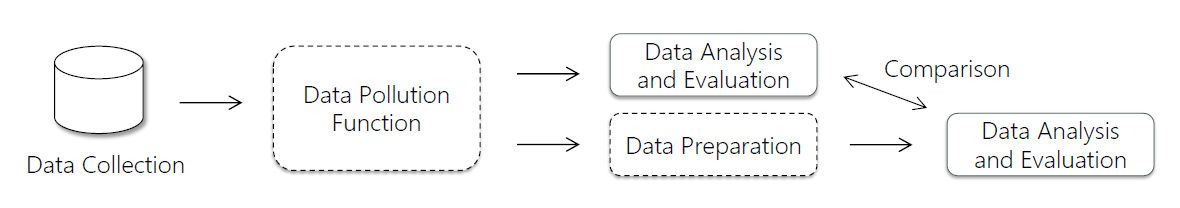

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [41]:
from sklearn.datasets import make_classification
from SCRIPTS.D_data_analysis import classification, encoding_categorical_variables
from SCRIPTS.E_plot_results import plot

print(sys.path)

['/home/claudio/DataQuality/DQ_project', '/home/claudio/miniconda3/envs/environmentAI_gpu/lib/python39.zip', '/home/claudio/miniconda3/envs/environmentAI_gpu/lib/python3.9', '/home/claudio/miniconda3/envs/environmentAI_gpu/lib/python3.9/lib-dynload', '', '/home/claudio/miniconda3/envs/environmentAI_gpu/lib/python3.9/site-packages']


# Data Creation and Exploration 

In [4]:

# DEFAULT PARAMETERS FOR CLASSIFICATION
#X, y = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)

def make_dataset_for_classification(n_samples, n_features, n_informative, n_redundant, n_repeated, n_classes, n_clusters_per_class, weights, flip_y, class_sep, hypercube, seed):
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant,
                               n_repeated=n_repeated, n_classes=n_classes, n_clusters_per_class=n_clusters_per_class,
                               weights=weights, flip_y=flip_y, class_sep=class_sep, hypercube=hypercube, random_state=seed)
    return X, y


In [10]:
X, y = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)
df = pd.DataFrame(X)
print(df.head())


          0         1         2         3         4
0 -3.044852  0.401225  1.876653  1.566605 -2.132950
1  1.445783  1.330753  1.140285  0.706253  2.422165
2  2.404213  1.620161 -0.710273 -3.793487  1.183956
3  1.573431 -0.558834  0.359672  0.777892  2.637753
4 -0.849001  2.114740  3.329424 -1.255837 -1.173801


In [12]:
df.shape

(1000, 5)

In [14]:
df.columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']  

In [15]:
df.dtypes

feature_1    float64
feature_2    float64
feature_3    float64
feature_4    float64
feature_5    float64
dtype: object

In [16]:
duplicates = df.duplicated()
print(duplicates.any())

False


<Axes: >

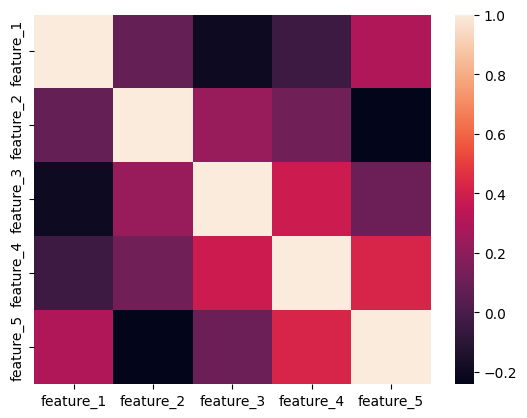

In [19]:
corr = df.corr(method ='spearman',numeric_only=True)
sns.heatmap(corr)

In [21]:
# Creating scatter plots for combinations of columns
def plot_creator(X):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Creating a 2x3 grid of subplots

    for i in range(5):  # Iterate through each column
        row = i // 3  # Determine subplot row
        col = i % 3   # Determine subplot column
        axs[row, col].scatter(X[:, i], X[:, (i + 1) % 5])  # Plot current column against next column 
        axs[row, col].set_xlabel(f'Column {i+1}')
        axs[row, col].set_ylabel(f'Column {(i + 1) % 5 + 1}')

    plt.tight_layout()
    plt.show()

In [6]:
#Creates a mask over the dataset to select randomically the desired percentage of the data to pollute
def mask_creator(percentage):
    mask = np.random.rand(len(df)) < percentage
    return mask

# Duplicates - Pollution Techniques
1) Add random noise to some columns (the number of columns can be decided differentiating through the different datasets)
2) Data scaling and trasformation applying a linear function to the dataset (the function can be decided differentiating through the different datasets)
3) Rounding the data, changing the number of decimals (the number of decimals discarded can be decided differentiating through the different datasets)

At the end the scaling pollution technique was not used because considered very similiar to the noising technique and so was preferred to apply the noising and the rounding to cover all the interesting combination among those techniques


In [7]:
#The function that actually pollutes the data
#It takes as input the datset, the mask used to identify the row to pollute, the number of duplicates to create, 
#the function to use to pollute the data, the parameter of the function (which is specific for each technique used),
#the list of modified columns (which is used to keep track of the columns modified for each row in case they have to be reused/discarded
#for combining techniques), a boolean (combining) to determine if the techniques are combined on DIFFERENT COLUMNS of the same row,
#a boolean (together) to determine if the user wants to pollute the SAME COLUMNS applying different techniques to the same feature,
#and a list of labels to which must be added the labels of the polluted data for the ext classification task

def polluting_data(dataset, mask, duplicates, function, parameter, modified, combining, together, labels):
    polluted_data = []
    #scanning all the rows of the dataset
    for row in range(len(dataset)):
        #The column polluted is only one 
        if(not combining):
            #If the current row has to be duplicated
            if(mask[row]):
                #Different columns are polluted with only one technique
                if(not together):
                    #Deciding randomically which columns to pollute
                    columns = np.random.permutation(5)[:duplicates]
                    modified.append(columns)
                    labels.append(y[row])
                #The rows are being polluted with the second technique so the column must be the same as the one used for the first technique
                else:
                    columns = modified[row]
                    
                pollution(dataset[row], function, parameter, columns, polluted_data)
        #Different columns are polluted with more than one techniques     
        else:
            columns = np.random.permutation(5)[:duplicates]
            #The columns already polluted are discarded to select a column which has not been polluted yet
            while all(elem in modified[row] for elem in columns):
                columns = np.random.permutation(5)[:duplicates]
            modified[row] = np.append(modified[row], columns)
            pollution(dataset[row], function, parameter, columns, polluted_data)
    return polluted_data


def pollution(row, function, parameter, columns, polluted_data):
            new_polluted_row = []
            for value in row:
                if(np.isin(np.where(row == value)[0], columns)):
                    if(function == "round"):
                        new_polluted_row = np.append(new_polluted_row, np.array([np.round(value, decimals=parameter)], dtype='float64'))
                    elif(function == "noise"):
                        new_polluted_row = np.append(new_polluted_row, np.array([value+parameter], dtype='float64'))
                    elif(function == "scale"):
                        new_polluted_row = np.append(new_polluted_row, np.array([value*parameter], dtype='float64'))

                else:
                    new_polluted_row = np.append(new_polluted_row, np.array([value], dtype='float64'))

            polluted_data.append(new_polluted_row)
    



In [8]:
#plot_creator(df.values)

In [8]:
#Example of polluting the data with the noise technique 
#The percentage of the data to pollute is 1.0 to immediately show the corretness of the technique
parameter_noise = np.random.normal(0, 0.1)

modified_noise_try = []
labels_noise_try = []
mask_noise_try = mask_creator(1.0)

noise_array_try = polluting_data(X, mask_noise_try, 2, "noise", parameter_noise, modified_noise_try, False, False, labels_noise_try)
noise_data_try = pd.DataFrame(noise_array_try)

print(df.head())
print(noise_data_try.head())
#plot_creator(noise_data.values)

          0         1         2         3         4
0 -3.044852  0.401225  1.876653  1.566605 -2.132950
1  1.445783  1.330753  1.140285  0.706253  2.422165
2  2.404213  1.620161 -0.710273 -3.793487  1.183956
3  1.573431 -0.558834  0.359672  0.777892  2.637753
4 -0.849001  2.114740  3.329424 -1.255837 -1.173801
          0         1         2         3         4
0 -3.044852  0.457764  1.876653  1.623144 -2.132950
1  1.445783  1.330753  1.196824  0.706253  2.478704
2  2.404213  1.676700 -0.710273 -3.793487  1.240495
3  1.629970 -0.558834  0.359672  0.777892  2.694292
4 -0.849001  2.114740  3.329424 -1.199298 -1.117262


In [9]:
#Example of polluting the data with the scale technique

parameter_round = np.random.randint(2, 4)

modified_round_try = []
labels_round_try = []
mask_round_try = mask_creator(1.0)

round_array_try = polluting_data(X, mask_round_try, 2, "round", parameter_round, modified_round_try, False, False, labels_round_try)
round_data_try = pd.DataFrame(round_array_try)

print(df.head())
print(round_data_try.head())
#plot_creator(scale_data.values)

          0         1         2         3         4
0 -3.044852  0.401225  1.876653  1.566605 -2.132950
1  1.445783  1.330753  1.140285  0.706253  2.422165
2  2.404213  1.620161 -0.710273 -3.793487  1.183956
3  1.573431 -0.558834  0.359672  0.777892  2.637753
4 -0.849001  2.114740  3.329424 -1.255837 -1.173801
          0         1         2         3         4
0 -3.040000  0.401225  1.876653  1.570000 -2.132950
1  1.450000  1.330000  1.140285  0.706253  2.422165
2  2.404213  1.620161 -0.710273 -3.790000  1.180000
3  1.573431 -0.558834  0.360000  0.780000  2.637753
4 -0.849001  2.110000  3.329424 -1.260000 -1.173801


In [10]:
#Example of polluting different columns of the same row with different techniques

parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

modified_combining_try = []
labels_combining_try = []
mask_combining_try = mask_creator(1.0)

noise_array_combining_try = polluting_data(X, mask_combining_try, 2, "noise", parameter_noise, modified_combining_try, False, False, labels_combining_try)

combining_array = polluting_data(noise_array_combining_try, mask_combining_try, 1, "round", parameter_round, modified_combining_try, True, False, labels_combining_try)
combining_data = pd.DataFrame(combining_array)
print(df.head())
print(combining_data.head())

#plot_creator(noise_round_data.values)

          0         1         2         3         4
0 -3.044852  0.401225  1.876653  1.566605 -2.132950
1  1.445783  1.330753  1.140285  0.706253  2.422165
2  2.404213  1.620161 -0.710273 -3.793487  1.183956
3  1.573431 -0.558834  0.359672  0.777892  2.637753
4 -0.849001  2.114740  3.329424 -1.255837 -1.173801
          0         1         2         3         4
0 -3.044852  0.401000  2.009085  1.699038 -2.132950
1  1.578216  1.463186  1.140000  0.706253  2.422165
2  2.404000  1.620161 -0.577840 -3.661054  1.183956
3  1.573431 -0.559000  0.492105  0.777892  2.770185
4 -0.716568  2.247172  3.329424 -1.256000 -1.173801


In [11]:
#Example of polluting the same columns of the same row with different techniques

parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

modified_together_try = []
labels_together_try = []
mask_together_try = mask_creator(1.0)

noise_array_together_try = polluting_data(X, mask_together_try, 2, "noise", parameter_noise, modified_together_try, False, False, labels_together_try)

mask_all_ones_try = np.ones(len(noise_array_together_try), dtype=bool)

together_array_try = polluting_data(noise_array_together_try, mask_all_ones_try, 2, "round", parameter_round, modified_together_try, False, True, labels_together_try)
together_data_try = pd.DataFrame(together_array_try)

print(df.head())
print(together_data_try.head())

          0         1         2         3         4
0 -3.044852  0.401225  1.876653  1.566605 -2.132950
1  1.445783  1.330753  1.140285  0.706253  2.422165
2  2.404213  1.620161 -0.710273 -3.793487  1.183956
3  1.573431 -0.558834  0.359672  0.777892  2.637753
4 -0.849001  2.114740  3.329424 -1.255837 -1.173801
          0         1         2         3         4
0 -3.044852  0.271000  1.876653  1.436000 -2.132950
1  1.445783  1.200000  1.140285  0.576000  2.422165
2  2.274000  1.620161 -0.710273 -3.924000  1.183956
3  1.573431 -0.558834  0.359672  0.647000  2.507000
4 -0.849001  1.984000  3.329424 -1.255837 -1.304000


# Duplicates - Data pollution with 10 different techniques 
1) Noising 1 column 
2) Rounding 1 column 
3) Noising 2 columns of the same row 
4) Rounding 2 columns of the same row 
5) Noising 1 column, rounding a different column of the same row
6) Noising and rounding applied together to 2 columns of the same row 
7) Noising 3 different columns of the same row
8) Rounding 3 different columns of the same row 
9) Noising 2 columns, rounding 1 different column of the same row 
10) Noising 1 column, rounding 2 different columns of the same row

In [12]:
#1) Noising 1 column

datasets_noise_one = [] #Array that contains the 10 dataset polluted with noise on 1 column with different percentages of duplicates
labels_noise_one = [] #Array that contains the labels of the duplicated datasets 
parameter = np.random.normal(0, 0.1)

for i in range(10):
    
    modified_noise = [] #Array that contains the columns modified for each row of the current dataset
    labels_noise_one_array = [] #Array that contains the labels of the current dataset
    mask_noise = mask_creator(0.05*(i+1)) #Mask used to select the rows to pollute which increaments by 5% each iteration
    
    noise_array = polluting_data(X, mask_noise, 1, "noise", parameter, modified_noise, False, False, labels_noise_one_array)
    noise_data = pd.DataFrame(noise_array)

    datasets_noise_one.append(noise_data.values)
    labels_noise_one.append(labels_noise_one_array)

In [13]:
#2) Rounding 1 column 

datasets_round_one = []
labels_round_one = []
parameter = np.random.randint(2, 4)

for i in range(10): 

    modified_round = []
    labels_round_one_array = []
    mask_round = mask_creator(0.05*(i+1))
    
    round_array = polluting_data(X, mask_round, 1, "round", parameter, modified_round, False, False, labels_round_one_array)
    round_data = pd.DataFrame(round_array)

    datasets_round_one.append(round_data.values)
    labels_round_one.append(labels_round_one_array)

In [14]:
#3) Noising 2 columns of the same row

datasets_noise_two = []
labels_noise_two = []
parameter = np.random.normal(0, 0.1)

for i in range(10):
    
    modified_noise_two = []
    labels_noise_two_array = []
    mask_noise_two = mask_creator(0.05*(i+1))
    
    noise_array_two = polluting_data(X, mask_noise_two, 2, "noise", parameter, modified_noise_two, False, False, labels_noise_two_array)
    noise_data_two = pd.DataFrame(noise_array_two)

    datasets_noise_two.append(noise_data_two.values)
    labels_noise_two.append(labels_noise_two_array)

In [15]:
#4) Rounding 2 columns of the same row

datasets_round_two = []
labels_round_two = []
parameter = np.random.randint(2, 4)

for i in range(10):
    
    modified_round_two = []
    labels_round_two_array = []
    mask_round_two = mask_creator(0.05*(i+1))
    
    round_array_two = polluting_data(X, mask_round_two, 2, "round", parameter, modified_round_two, False, False, labels_round_two_array)
    round_data_two = pd.DataFrame(round_array_two)

    datasets_round_two.append(round_data_two.values)
    labels_round_two.append(labels_round_two_array)

In [16]:
#5) Noising 1 column, rounding a different column of the same row

datasets_noise_round_one = []
labels_noise_round_one = []
parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

for i in range(10):
    
    modified_noise_round_one = []
    labels_noise_round_one_array = []
    mask_noise_round_one = mask_creator(0.05*(i+1))

    #In this case the two techniques are combined on different columns of the same row, so the first pollution is applied to the whole dataset
    #and then the second one is applied to the already polluted dataset using the Modified_noise_round_one array to keep track of the columns already 
    #polluted
    #In the second pollution is not important the mask because in the polluting_data function in this case the mask is not used, the pollution 
    #is applied to all the rows of the input dataset
    
    noise_round_array_one = polluting_data(X, mask_noise_round_one, 1, "noise", parameter_noise, modified_noise_round_one, False, False, labels_noise_round_one_array)
    noise_round_array_one = polluting_data(noise_round_array_one, mask_noise_round_one, 1, "round", parameter_round, modified_noise_round_one, True, False, labels_noise_round_one_array)
    noise_round_data_one = pd.DataFrame(noise_round_array_one)

    datasets_noise_round_one.append(noise_round_data_one.values)
    labels_noise_round_one.append(labels_noise_round_one_array)  
    

In [17]:
#6) Noising and rounding applied together to 2 columns of the same row 

datasets_round_noise_together = []
labels_noise_round_together = []
parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

for i in range(10):
    
    modified_noise_round_together = []
    labels_noise_round_together_array = []
    mask_noise_round_together = mask_creator(0.05*(i+1))
    
    #In this case the two techniques are combined on the same columns of the same row, so the first pollution is applied to the whole dataset
    #and then the second one is applied to the already polluted dataset using the Modified_noise_round_together array to keep track of the columns 
    #already polluted in order to apply to them the second technique
    #In the second pollution is necessary to use a mask with all ones in order to apply the pollution to all the input dataset because in this case
    #the polluting_data function enters the branch in which is considered the mask to select the rows to be polluted
    
    noise_round_array_together = polluting_data(X, mask_noise_round_together, 2, "noise", parameter_noise, modified_noise_round_together, False, False, labels_noise_round_together_array)
    
    mask_all_ones = np.ones(len(noise_round_array_together), dtype=bool)

    noise_round_array_together = polluting_data(noise_round_array_together, mask_all_ones, 2, "round", parameter_round, modified_noise_round_together, False, True, labels_noise_round_together_array)
    noise_round_data_together = pd.DataFrame(noise_round_array_together)

    datasets_round_noise_together.append(noise_round_data_together.values)
    labels_noise_round_together.append(labels_noise_round_together_array)
    
    

In [18]:
#7) Noising 3 different columns of the same row

datasets_noise_three = []
labels_noise_three = []
parameter = np.random.normal(0, 0.1)

for i in range(10):
    
    modified_noise_three = []
    labels_noise_three_array = []
    mask_noise_three = mask_creator(0.05*(i+1))
    
    noise_array_three = polluting_data(X, mask_noise_three, 3, "noise", parameter, modified_noise_three, False, False, labels_noise_three_array)
    noise_data_three = pd.DataFrame(noise_array_three)

    datasets_noise_three.append(noise_data_three.values)
    labels_noise_three.append(labels_noise_three_array)


In [19]:
#8) Rounding 3 different columns of the same row

datasets_round_three = []
labels_round_three = []
parameter = np.random.randint(2, 4)

for i in range(10):
    
    modified_round_three = []
    labels_round_three_array = []
    mask_round_three = mask_creator(0.05*(i+1))
    
    round_array_three = polluting_data(X, mask_round_three, 3, "round", parameter, modified_round_three, False, False, labels_round_three_array)
    round_data_three = pd.DataFrame(round_array_three)

    datasets_round_three.append(round_data_three.values)
    labels_round_three.append(labels_round_three_array)


In [20]:
#9) Noising 2 columns, rounding a different column of the same row

datasets_noise_round_two_one = []
labels_noise_round_two_one = []
parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

for i in range(10):
    
    modified_noise_round_two_one = []
    labels_noise_round_two_one_array = []
    mask_noise_round_two_one = mask_creator(0.05*(i+1))

    #Same case as the one in which noise and round are applied to to different columns but in this case the noising is applied to 2 columns
    #and the rounding to 1 column obtaining a combination that involves 3 different columns

    noise_round_array_two_one = polluting_data(X, mask_noise_round_two_one, 2, "noise", parameter_noise, modified_noise_round_two_one, False, False, labels_noise_round_two_one_array)
    noise_round_array_two_one = polluting_data(noise_round_array_two_one, mask_noise_round_two_one, 1, "round", parameter_round, modified_noise_round_two_one, True, False, labels_noise_round_two_one_array)
    noise_round_data_two_one = pd.DataFrame(noise_round_array_two_one)

    datasets_noise_round_two_one.append(noise_round_data_two_one.values)
    labels_noise_round_two_one.append(labels_noise_round_two_one_array)
    

In [21]:
#10) Noising 1 column, rounding 2 different columns of the same row

datasets_noise_round_one_two = []
labels_noise_round_one_two = []
parameter_noise = np.random.normal(0, 0.1)
parameter_round = np.random.randint(2, 4)

for i in range(10):
    
    modified_noise_round_one_two = []
    labels_noise_round_one_two_array = []
    mask_noise_round_one_two = mask_creator(0.05*(i+1))
    
    #Same case as the one in which noise and round are applied to 2 different columns but in this case the noising is applied to 1 column
    #and the rounding to 2 columns obtaining a combination that involves 3 different columns

    noise_round_array_one_two = polluting_data(X, mask_noise_round_one_two, 1, "noise", parameter_noise, modified_noise_round_one_two, False, False, labels_noise_round_one_two_array)
    noise_round_array_one_two = polluting_data(noise_round_array_one_two, mask_noise_round_one_two, 2, "round", parameter_round, modified_noise_round_one_two, True, False, labels_noise_round_one_two_array)
    noise_round_data_one_two = pd.DataFrame(noise_round_array_one_two)

    datasets_noise_round_one_two.append(noise_round_data_one_two.values)
    labels_noise_round_one_two.append(labels_noise_round_one_two_array)
    

In [22]:
#This function is used to spread the duplicates into the original dataset without changing the order of the rows
#It takes as input the duplicates and the relatives labels and returns the final polluted dataset and labels 

def duplicates_spreader(duplicates, labels):
    final_polluted_dataset = X
    final_polluted_labels = y

    for i in range(len(duplicates)):
        randomic_index = np.random.randint(0, len(final_polluted_dataset))
        final_polluted_dataset = np.insert(final_polluted_dataset, randomic_index, duplicates[i], axis=0)
        final_polluted_labels = np.insert(final_polluted_labels, randomic_index, labels[i], axis=0)
    return final_polluted_dataset, final_polluted_labels
        

In [23]:
#Applying the duplicates_spreader function to all the datasets polluted with the same technique obtaining the final polluted datasets and labels
#which conists of the original dataset with the duplicates spreaded into it.
#The procedure involves a for cycle because must be applied to all the datasets polluted with the same combination pf techniques but having 
#different percentages of duplicates

final_datasets_noise_one = []
final_labels_noise_one = []
final_datasets_round_one = []
final_labels_round_one = []
final_datasets_noise_two = []
final_labels_noise_two = []
final_datasets_round_two = []
final_labels_round_two = []
final_datasets_noise_round_one = []
final_labels_noise_round_one = []
final_datasets_round_noise_together = []
final_labels_noise_round_together = []
final_datasets_noise_three = []
final_labels_noise_three = []
final_datasets_round_three = []
final_labels_round_three = []
final_datasets_noise_round_two_one = []
final_labels_noise_round_two_one = []
final_datasets_noise_round_one_two = []
final_labels_noise_round_one_two = []


for i in range(10):
    dataset, label = duplicates_spreader(datasets_noise_one[i], labels_noise_one[i])
    final_datasets_noise_one.append(dataset)
    final_labels_noise_one.append(label)

    dataset, label = duplicates_spreader(datasets_round_one[i], labels_round_one[i])
    final_datasets_round_one.append(dataset)
    final_labels_round_one.append(label)

    dataset, label = duplicates_spreader(datasets_noise_two[i], labels_noise_two[i])
    final_datasets_noise_two.append(dataset)
    final_labels_noise_two.append(label)

    dataset, label = duplicates_spreader(datasets_round_two[i], labels_round_two[i])
    final_datasets_round_two.append(dataset)
    final_labels_round_two.append(label)

    dataset, label = duplicates_spreader(datasets_noise_round_one[i], labels_noise_round_one[i])
    final_datasets_noise_round_one.append(dataset)
    final_labels_noise_round_one.append(label)

    dataset, label = duplicates_spreader(datasets_round_noise_together[i], labels_noise_round_together[i])
    final_datasets_round_noise_together.append(dataset)
    final_labels_noise_round_together.append(label)

    dataset, label = duplicates_spreader(datasets_noise_three[i], labels_noise_three[i])
    final_datasets_noise_three.append(dataset)
    final_labels_noise_three.append(label)

    dataset, label = duplicates_spreader(datasets_round_three[i], labels_round_three[i])
    final_datasets_round_three.append(dataset)
    final_labels_round_three.append(label)

    dataset, label = duplicates_spreader(datasets_noise_round_two_one[i], labels_noise_round_two_one[i])
    final_datasets_noise_round_two_one.append(dataset)
    final_labels_noise_round_two_one.append(label)

    dataset, label = duplicates_spreader(datasets_noise_round_one_two[i], labels_noise_round_one_two[i])
    final_datasets_noise_round_one_two.append(dataset)
    final_labels_noise_round_one_two.append(label)
    
    


# Duplicates - Data Analysis and Evaluation 

In [24]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree","LogisticRegression","KNN","RandomForest","AdaBoost","MLP"]
SEED = 2023

def classifier_function(dataset, labels, title1, title2, title3):
    results_for_each_algorithm = []
    for algorithm in CLASSIFICATION_ALGORITHMS: 

        results_single_algorithm = []

        #Iterating for each dataset polluted with the same combination of techniques having different percentages of duplicates
        for i in range(0, 10): 
            
            X = dataset[i]
            y = labels[i]

            results_1_analysis = classification(X, y, algorithm, SEED)
            results_single_algorithm.append(results_1_analysis)

        results_for_each_algorithm.append(results_single_algorithm)

    plot(x_axis_values=[5,10,15,20,25,30,35,40,45,50], x_label="Percentage of duplicates", results=results_for_each_algorithm, title=title1, algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
    plot(x_axis_values=[5,10,15,20,25,30,35,40,45,50], x_label="Percentage of duplicates", results=results_for_each_algorithm, title=title2, algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
    plot(x_axis_values=[5,10,15,20,25,30,35,40,45,50], x_label="Percentage of duplicates", results=results_for_each_algorithm, title=title3, algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

Training for DecisionTree...


Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

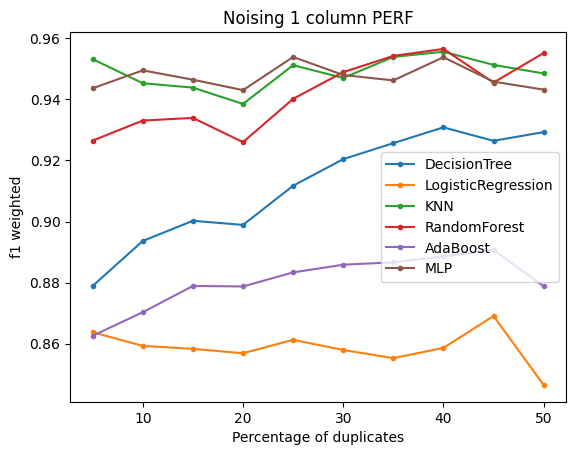

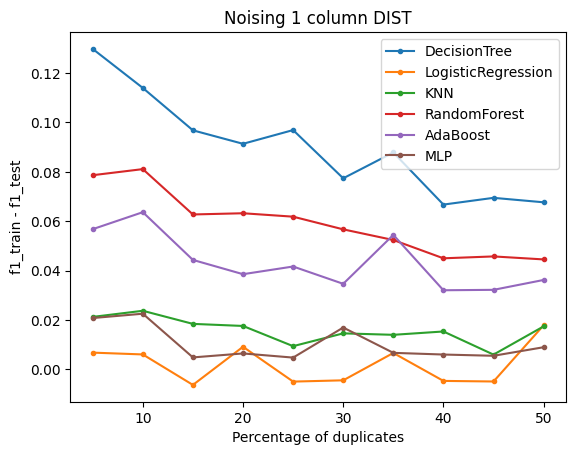

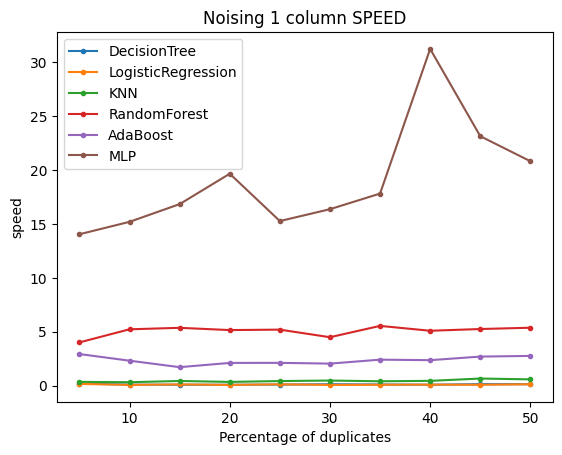

In [25]:
classifier_function(final_datasets_noise_one, final_labels_noise_one, "Noising 1 column PERF", "Noising 1 column DIST", "Noising 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

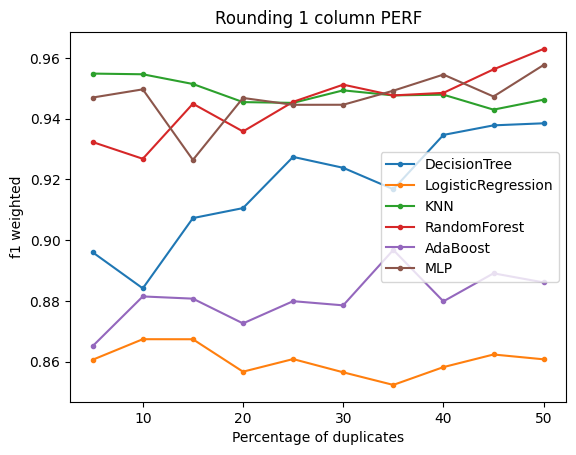

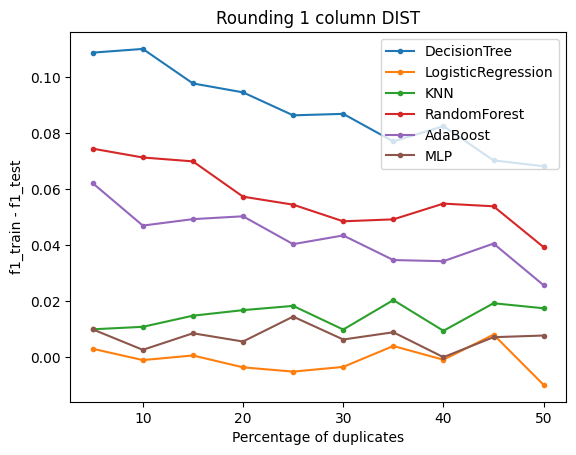

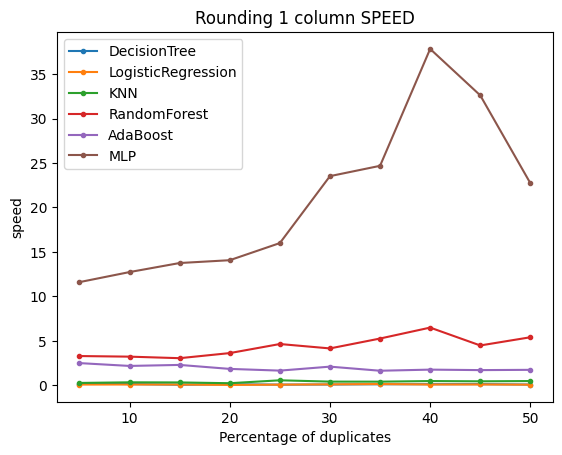

In [26]:
classifier_function(final_datasets_round_one, final_labels_round_one, "Rounding 1 column PERF", "Rounding 1 column DIST", "Rounding 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

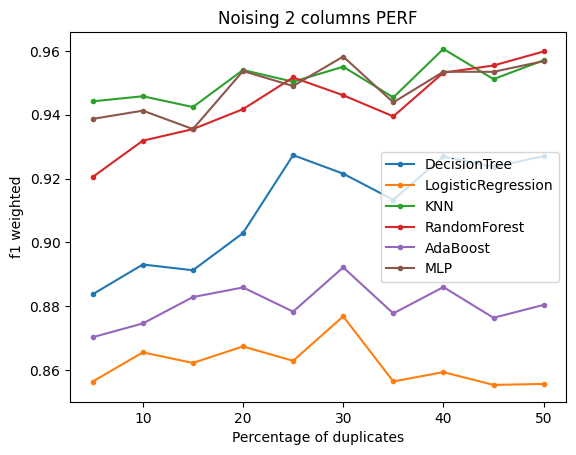

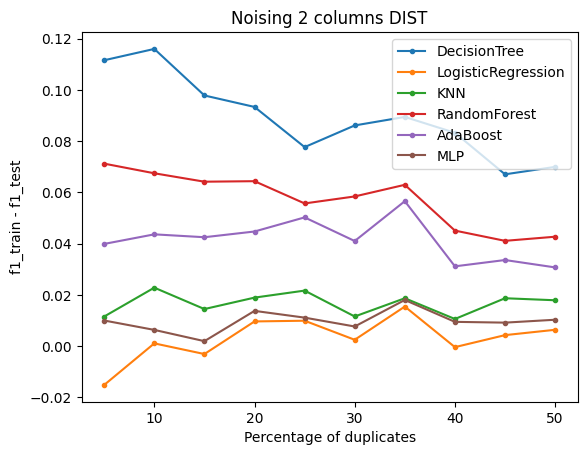

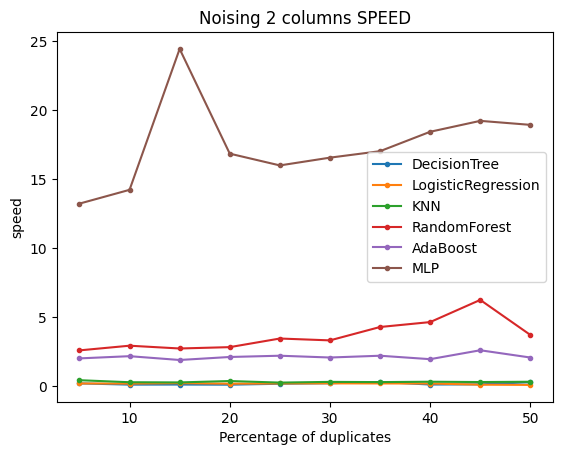

In [27]:
classifier_function(final_datasets_noise_two, final_labels_noise_two, "Noising 2 columns PERF", "Noising 2 columns DIST", "Noising 2 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

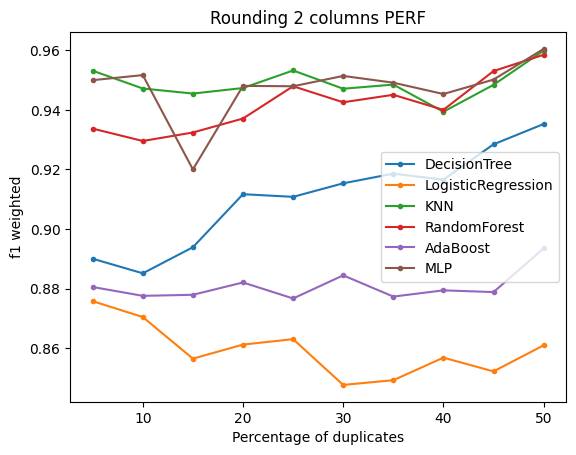

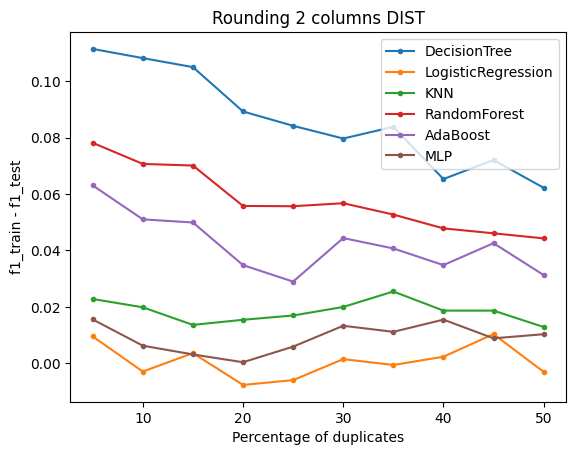

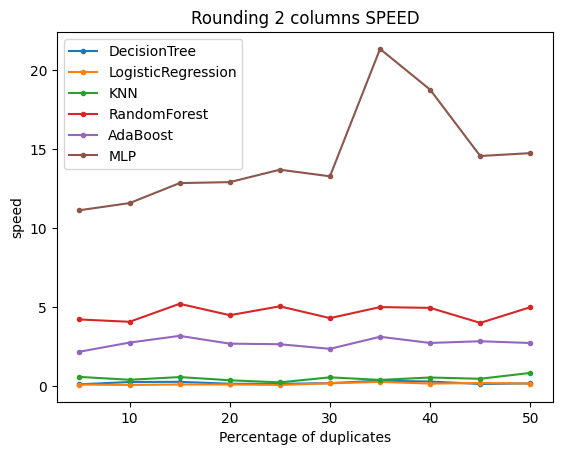

In [29]:
classifier_function(final_datasets_round_two, final_labels_round_two, "Rounding 2 columns PERF", "Rounding 2 columns DIST", "Rounding 2 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

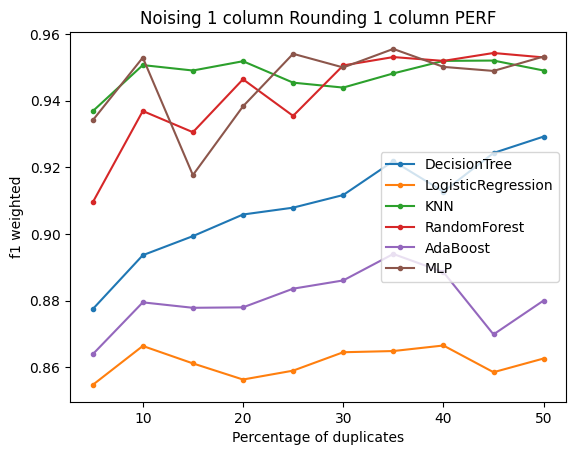

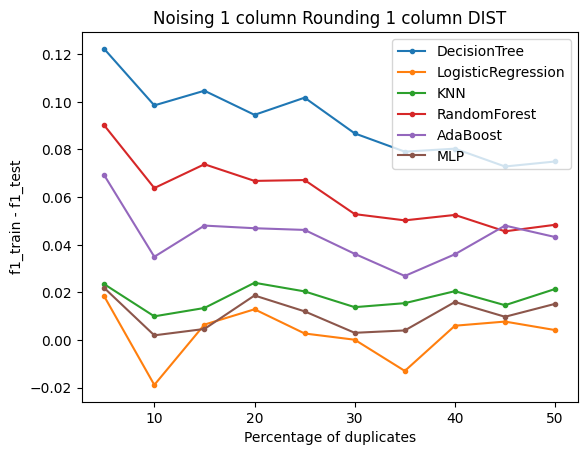

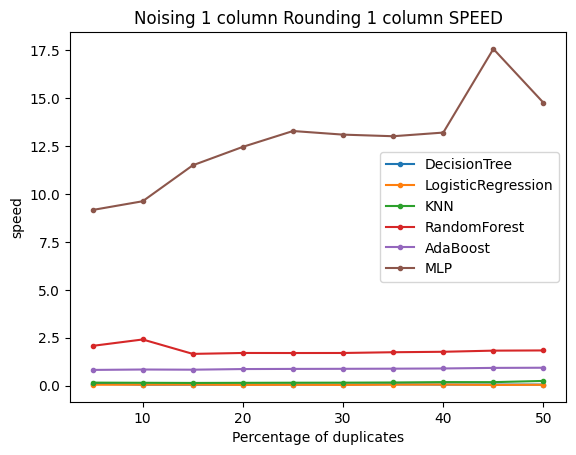

In [30]:
classifier_function(final_datasets_noise_round_one, final_labels_noise_round_one, "Noising 1 column Rounding 1 column PERF", "Noising 1 column Rounding 1 column DIST", "Noising 1 column Rounding 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

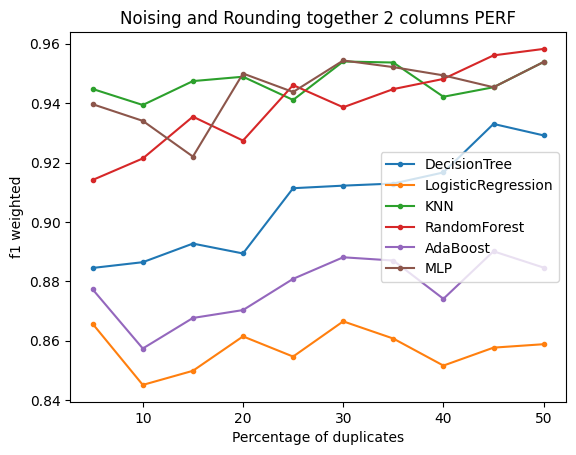

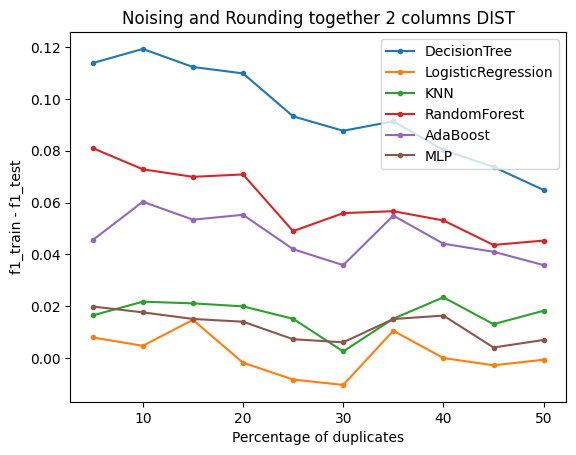

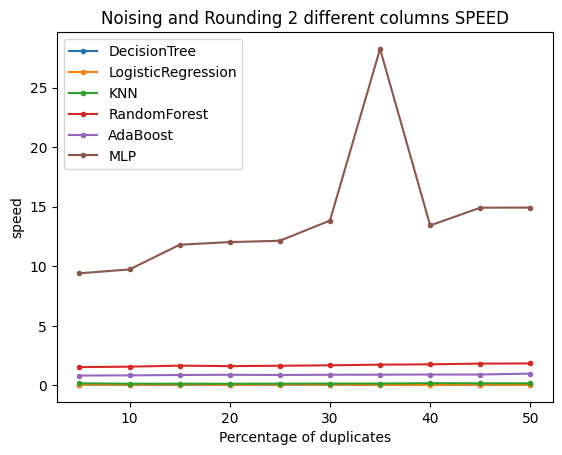

In [31]:
classifier_function(final_datasets_round_noise_together, final_labels_noise_round_together, "Noising and Rounding together 2 columns PERF", "Noising and Rounding together 2 columns DIST", "Noising and Rounding 2 different columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

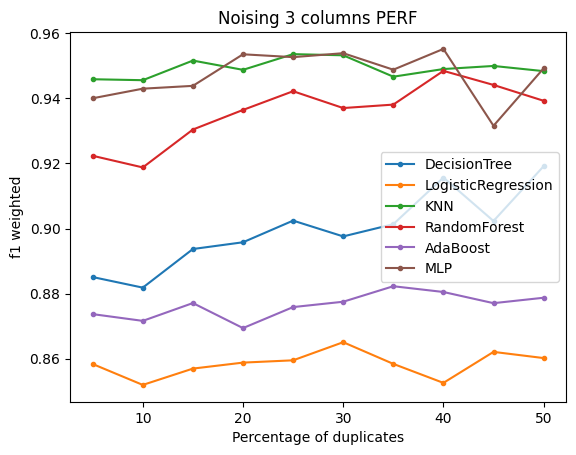

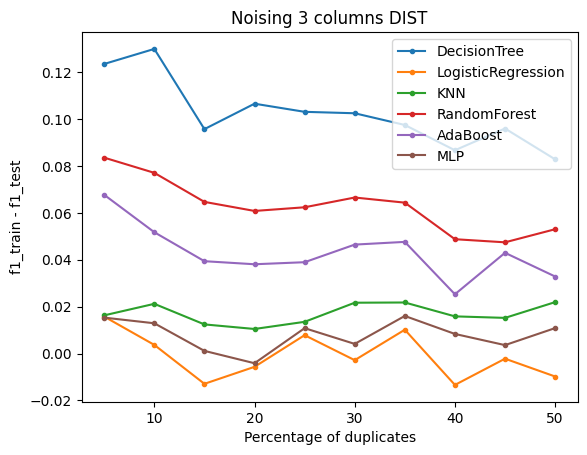

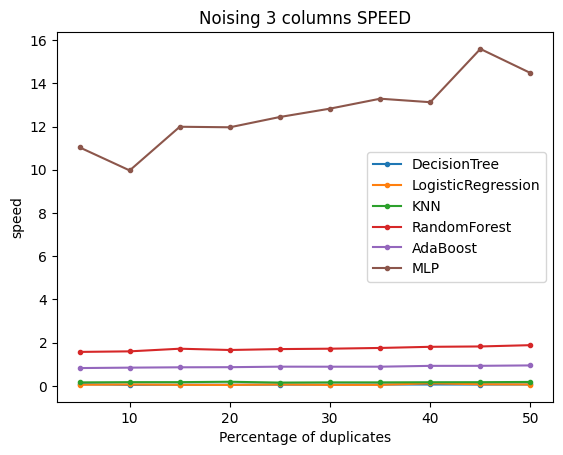

In [32]:
classifier_function(final_datasets_noise_three, final_labels_noise_three, "Noising 3 columns PERF", "Noising 3 columns DIST", "Noising 3 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

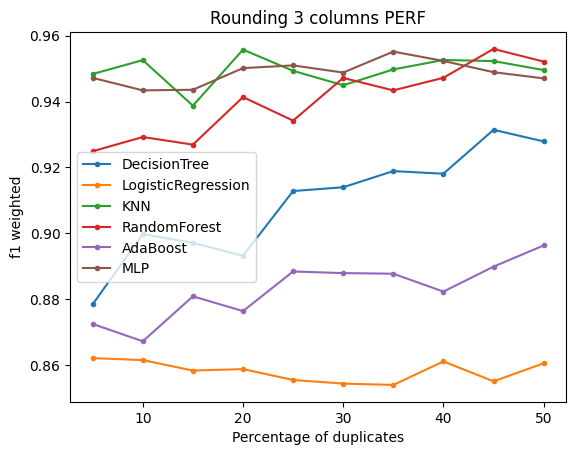

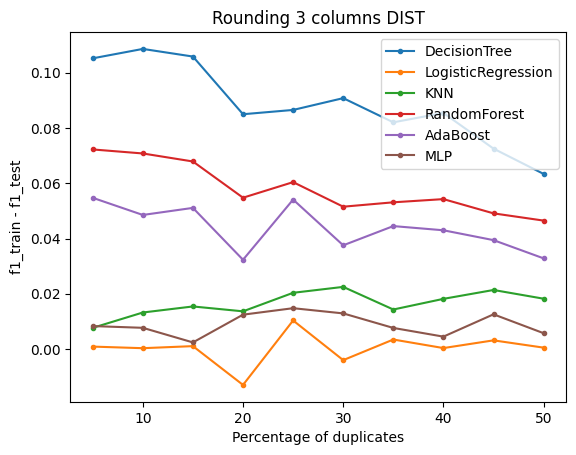

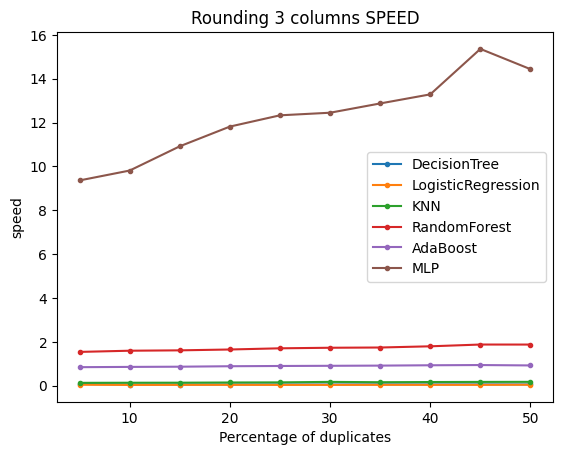

In [33]:
classifier_function(final_datasets_round_three, final_labels_round_three, "Rounding 3 columns PERF", "Rounding 3 columns DIST", "Rounding 3 columns SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

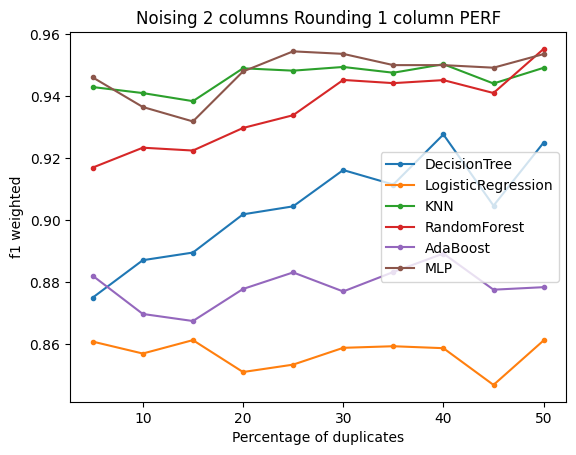

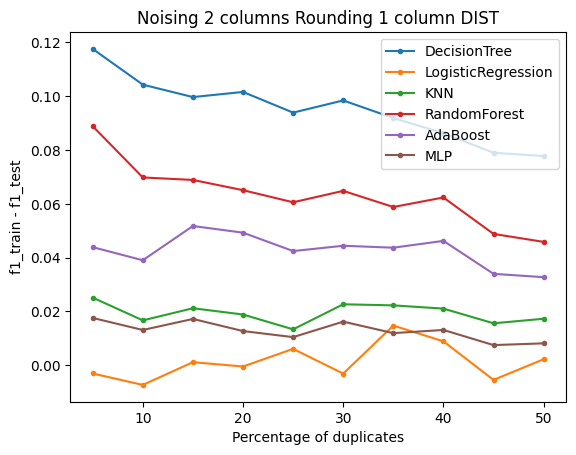

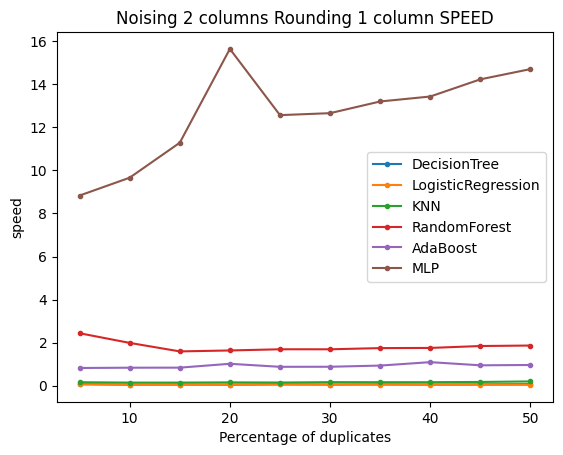

In [34]:
classifier_function(final_datasets_noise_round_two_one, final_labels_noise_round_two_one, "Noising 2 columns Rounding 1 column PERF", "Noising 2 columns Rounding 1 column DIST", "Noising 2 columns Rounding 1 column SPEED")

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

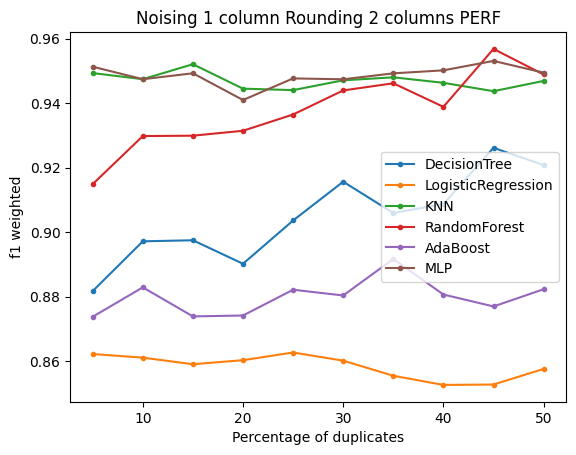

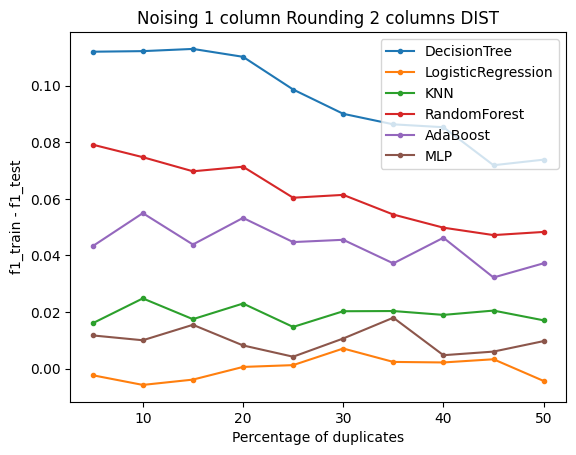

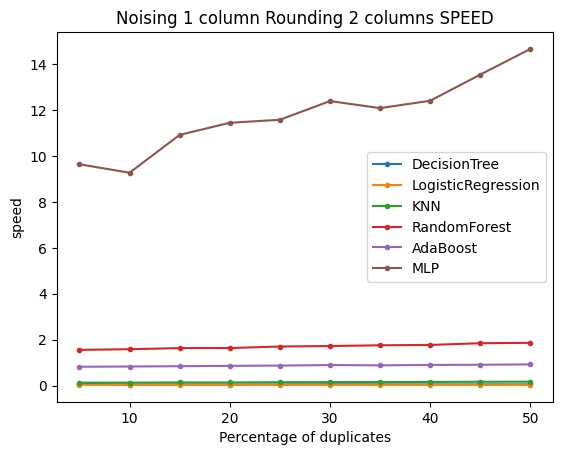

In [35]:
classifier_function(final_datasets_noise_round_one_two, final_labels_noise_round_one_two, "Noising 1 column Rounding 2 columns PERF", "Noising 1 column Rounding 2 columns DIST", "Noising 1 column Rounding 2 columns SPEED")

# Duplicates - Data Cleaning 

# Duplicates - Data Analysis and Evaluation after Cleaning 

# Variable types - Data pollution

Correlation analysis: we want to identify relationships between variables using correlation coefficients

To generate new features, we exploit some dependency that we appositely create between the existing features and the newly generated one that we want to be categorical or boolean

In [23]:
from enum import Enum

#enumerate positive or negative numbers
class Sign(Enum):
    POSITIVE = 1
    NEGATIVE = 2

#Enumerate some colors
class Color(Enum):
    GREEN = 1
    BLUE = 2
    PURPLE = 3
    YELLOW = 4
    ORANGE = 5
    RED = 6


#Enumerate the numbers from 1 to 40
class Number(Enum):
    ONE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8
    NINE = 9
    TEN = 10
    ELEVEN = 11
    TWELVE = 12
    THIRTEEN = 13
    FOURTEEN = 14
    FIFTEEN = 15
    SIXTEEN = 16
    SEVENTEEN = 17
    EIGHTEEN = 18
    NINETEEN = 19
    TWENTY = 20
    TWENTYONE = 21
    TWENTYTWO = 22
    TWENTYTHREE = 23
    TWENTYFOUR = 24
    TWENTYFIVE = 25
    TWENTYSIX = 26
    TWENTYSEVEN = 27
    TWENTYEIGHT = 28
    TWENTYNINE = 29
    THIRTY = 30
    THIRTYONE = 31
    THIRTYTWO = 32
    THIRTYTHREE = 33
    THIRTYFOUR = 34
    THIRTYFIVE = 35
    THIRTYSIX = 36
    THIRTYSEVEN = 37
    THIRTYEIGHT = 38
    THIRTYNINE = 39
    FORTY = 40


First added feature: categorical column with two values

In [24]:
#function to create a new column based on the sum of the columns of the dataframe, assigning enum POS or NEG according to sign
def add_sum_POS_NEG(df):
    df['sum_sign'] = df.iloc[:, 0:4].sum(axis=1).apply(lambda x: Sign.POSITIVE if x > 0 else Sign.NEGATIVE)
    return df

#function to create a new column based on the sum of the columns of the dataframe, assigning TRUE or FALSE according to sign
def add_sum_POS_NEG_bool(df):
    df['sum_sign_positive'] = df.iloc[:, 0:4].sum(axis=1).apply(lambda x: True if x > 0 else False)
    return df


Second added feature: categorical column containing a color based on the value of the median absolute deviation

In [25]:
#funtion to generate a new column with the median absolute deviation of other columns of the dataframe
def add_median_absolute_deviation_column(df):
    df['mad_colors'] = df.iloc[:, 0:4].apply(lambda x: abs(x - x.median()).mean(), axis=1)
    return df


In [ ]:
#find the minimum and maximum value in the mad column
#print('min: '+str(df['mad'].min()))
#print('max: '+str(df['mad'].max()))

In [26]:


#replace the 'mad' value with a color according to fixed intervals
def mad_to_color(df):
    df['mad_colors'] = df['mad_colors'].apply(lambda x: Color.GREEN if x < 0.5 else Color.BLUE if x < 1.0 else Color.PURPLE if x < 1.5 else Color.YELLOW if x < 2.0 else Color.ORANGE if x < 2.5 else Color.RED)
    return df



In [27]:
def add_mad_colors(df):
    df = add_median_absolute_deviation_column(df)
    df = mad_to_color(df)
    return df

Third added feature: categorical column containing enumeration of number names, assigned according always to the mad but in a variable number and following equally wide intervals that depend on the specified number of intervals

In [28]:
def add_mad_numbers(df, num_intervals, col_name='mad_num'):

    if( num_intervals > 39): return df

    df[col_name] = df.iloc[:, 0:4].apply(lambda x: abs(x - x.median()).mean(), axis=1)
    max = df[col_name].max()
    min = df[col_name].min()
    interval_wide = (max - min)/num_intervals
    #print('max-min: '+str(df.max()['mad_num'] - df.min()['mad_num']))
    #print('interval_wide: '+str(interval_wide))
    
    # Convert Enum to list
    enum_list = list(Number)
    for i in range(0, num_intervals):
        df[col_name] = df[col_name].apply(lambda x: enum_list[i] if (isinstance(x, float)) and ( min + interval_wide * i <= x < min + interval_wide * (i + 1) ) else x)
    return df
    

#df = add_mad_numbers(df, 10)
#df



Test the functions:

In [30]:
df_test = pd.DataFrame(X)

add_sum_POS_NEG(df_test)
add_mad_colors(df_test)
add_mad_numbers(df_test, 10)
df_test

,0,1,2,3,4,sum_sign,mad_colors,mad_num
0,-3.044852,0.401225,1.876653,1.566605,-2.132950,Sign.POSITIVE,Color.YELLOW,Number.SIX
1,1.445783,1.330753,1.140285,0.706253,2.422165,Sign.POSITIVE,Color.GREEN,Number.ONE
2,2.404213,1.620161,-0.710273,-3.793487,1.183956,Sign.NEGATIVE,Color.ORANGE,Number.NINE
3,1.573431,-0.558834,0.359672,0.777892,2.637753,Sign.POSITIVE,Color.BLUE,Number.THREE
4,-0.849001,2.114740,3.329424,-1.255837,-1.173801,Sign.POSITIVE,Color.YELLOW,Number.EIGHT
...,...,...,...,...,...,...,...,...
995,0.852847,-0.726076,-2.160768,-3.265680,-0.749785,Sign.NEGATIVE,Color.PURPLE,Number.SIX
996,0.482150,0.830578,0.418977,1.189807,2.350933,Sign.POSITIVE,Color.GREEN,Number.ONE
997,0.173973,-1.095862,0.148571,-1.312195,1.049151,Sign.NEGATIVE,Color.BLUE,Number.THREE
998,-1.475855,-0.718746,-2.108539,-1.984390,-2.674930,Sign.NEGATIVE,Color.GREEN,Number.TWO


Briefly study the added columns:

In [31]:
#count the occurences of POSITIVE and NEGATIVE
df_test['sum_sign'].value_counts()

sum_sign
Sign.NEGATIVE    542
Sign.POSITIVE    458
Name: count, dtype: int64

<Axes: xlabel='sum_sign'>

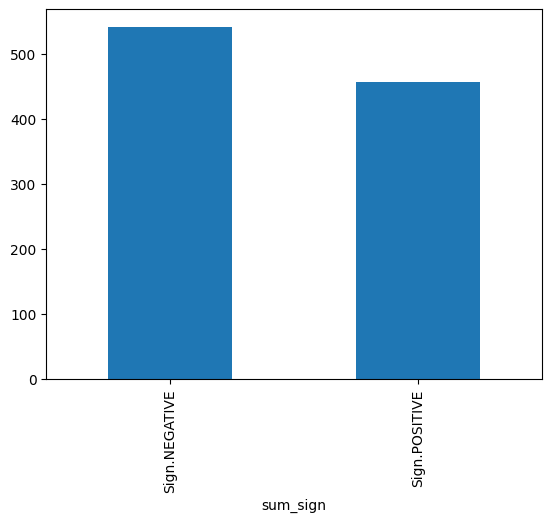

In [32]:
#print a histogram of the value counts in 'sum_sign' column
df_test['sum_sign'].value_counts().plot(kind='bar')

In [33]:
#count the occurences of the mad colors
df_test['mad_colors'].value_counts()

mad_colors
Color.BLUE      431
Color.PURPLE    332
Color.YELLOW    120
Color.GREEN      92
Color.ORANGE     24
Color.RED         1
Name: count, dtype: int64

<Axes: xlabel='mad_colors'>

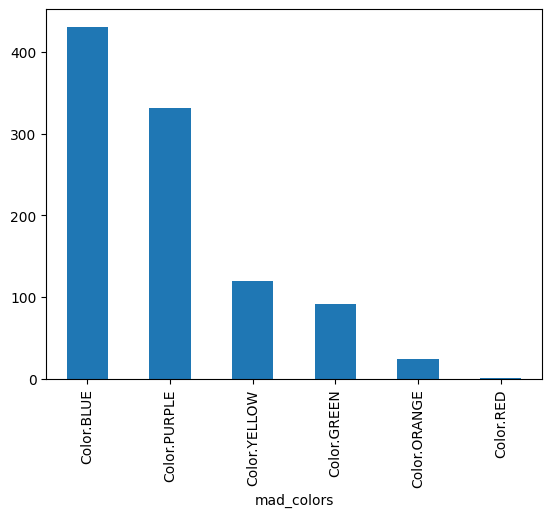

In [34]:
#print a histogram of the value counts in 'mad_colors' column
df_test['mad_colors'].value_counts().plot(kind='bar')

In [35]:
#count the occurences of the mad numbers
df_test['mad_num'].value_counts()

mad_num
Number.FOUR     230
Number.THREE    218
Number.FIVE     162
Number.TWO      138
Number.SIX      107
Number.SEVEN     58
Number.ONE       43
Number.EIGHT     30
Number.NINE      10
Number.TEN        4
Name: count, dtype: int64

<Axes: xlabel='mad_num'>

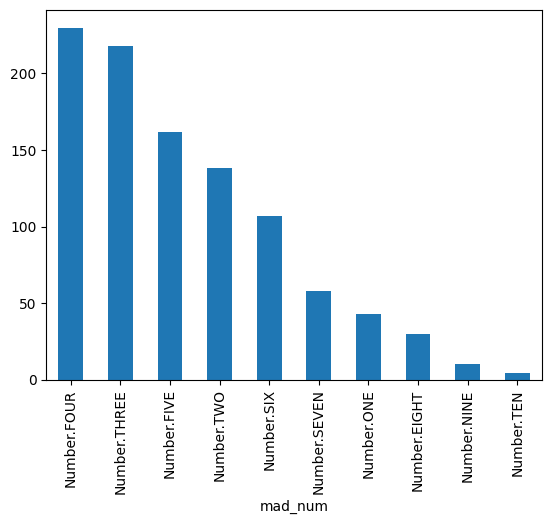

In [36]:
#print a histogram of the value counts in 'mad_num' column
df_test['mad_num'].value_counts().plot(kind='bar')

Generate datasets for 10 different experiments:

In [37]:
X_vt = []
df_vt = []
y_vt = []

#generate 10 random non-repeated integer seeds
seeds = np.random.choice(10000, 10, replace=False)

#generate 10 datasets for the experiments
for i in range (0,10):
    X_temp, y_temp = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=seeds[i])
    X_vt.append(X_temp)
    df_vt.append(pd.DataFrame(X_temp))
    y_vt.append(y_temp)

    #df_temp = pd.DataFrame(X_vt[i])
    #print(df_temp.head(3))

Pollute the 10 experiments with categorical columns in different measures

In [38]:
for i, df in enumerate(df_vt):
    if i == 0:
        #Ex1: boolean col
        add_sum_POS_NEG_bool(df)
    elif i == 1:
        #Ex2: colors
        add_mad_colors(df)
    elif i == 2:
        #Ex3: numbers 10
        add_mad_numbers(df, 10)
    elif i == 3:
        #Ex4: numbers 30
        add_mad_numbers(df, 30)
    elif i == 4:
        #Ex5: boolean col + sign string
        add_sum_POS_NEG_bool(df)
        add_sum_POS_NEG(df)
    elif i == 5:
        #Ex6: boolean col + numbers 10
        add_sum_POS_NEG_bool(df)
        add_mad_numbers(df, 10)
    elif i == 6:
        #Ex7: colors + numbers 10
        add_mad_colors(df)
        add_mad_numbers(df, 10)
    elif i == 7:
        #Ex8: colors + numbers 30
        add_mad_colors(df)
        add_mad_numbers(df, 30)
    elif i == 8:
        #Ex9: boolean col + colors + numbers 10
        add_sum_POS_NEG_bool(df)
        add_mad_colors(df)
        add_mad_numbers(df, 10)
    elif i == 9:
        #Ex10: boolean col + colors + numbers 10 + numbers 30
        add_sum_POS_NEG_bool(df)
        add_mad_colors(df)
        add_mad_numbers(df, 10)
        add_mad_numbers(df, 30, "mad_num_2")
    else:
        print("error in pollution")

In [39]:
for i, df in enumerate(df_vt):
    print('\ndataset '+str(i)+":")
    print(df.head(3))


dataset 0:
          0         1         2         3         4  sum_sign_positive
0  1.823560 -1.378814 -0.905807  1.706049  0.868619               True
1  1.969029 -1.255320 -1.674939  1.752552  0.042525               True
2 -0.002119  0.056181  0.955813 -1.313577  2.820477              False

dataset 1:
          0         1         2         3         4  mad_colors
0 -0.449298  1.788455 -0.682549  0.967626 -0.486638  Color.BLUE
1  0.625786 -1.999561  0.308192 -0.417151  1.104302  Color.BLUE
2  2.564274  0.881461  0.839560  2.206687 -4.626506  Color.BLUE

dataset 2:
          0         1         2         3         4       mad_num
0 -5.406403  3.808047 -1.085360 -2.775311 -0.547049   Number.NINE
1  0.116277  1.798199 -3.121491 -1.380942 -1.245192   Number.FIVE
2 -1.690498  0.574716 -1.667472 -0.230749  2.678531  Number.THREE

dataset 3:
          0         1         2         3         4       mad_num
0  0.843613 -1.597306  1.278257  0.137847 -1.706134   Number.NINE
1  2.062454 -0.4

# Variable types - data anlysis and evaluation

ML algorithms require numerical input, so we firstly encode categorical variables to convert qualitative attributes into numerical values.

In [42]:
for i in range(0,10):
    df_vt[i] = encoding_categorical_variables(df_vt[i])

In [43]:
for i, df in enumerate(df_vt):
    print('\ndataset '+str(i)+":")
    print(df.head(3))


dataset 0:
          0         1         2         3         4
0  1.823560 -1.378814 -0.905807  1.706049  0.868619
1  1.969029 -1.255320 -1.674939  1.752552  0.042525
2 -0.002119  0.056181  0.955813 -1.313577  2.820477

dataset 1:
          0         1         2         3         4  mad_colors_Color.BLUE  \
0 -0.449298  1.788455 -0.682549  0.967626 -0.486638                   True   
1  0.625786 -1.999561  0.308192 -0.417151  1.104302                   True   
2  2.564274  0.881461  0.839560  2.206687 -4.626506                   True   

   mad_colors_Color.PURPLE  mad_colors_Color.YELLOW  mad_colors_Color.GREEN  \
0                    False                    False                   False   
1                    False                    False                   False   
2                    False                    False                   False   

   mad_colors_Color.ORANGE  mad_colors_Color.RED  mad_colors_nan  
0                    False                 False           False  
1   

In [44]:
#convert dataframe back to numpy.ndarray
X_vt_polluted = [df.to_numpy() for df in df_vt]

In [45]:
#print X_vt
print(X_vt_polluted[0])

[[ 1.82356019e+00 -1.37881394e+00 -9.05806624e-01  1.70604926e+00
   8.68619379e-01]
 [ 1.96902932e+00 -1.25532005e+00 -1.67493925e+00  1.75255236e+00
   4.25250668e-02]
 [-2.11935263e-03  5.61809042e-02  9.55813312e-01 -1.31357667e+00
   2.82047697e+00]
 ...
 [-2.66611885e-01 -4.08480745e-01  7.37734053e-01  1.81463395e+00
  -3.60204492e+00]
 [-2.11377118e-01  3.28174451e+00 -1.67037319e+00  5.06066193e-01
   3.22437397e+00]
 [ 2.32290160e+00 -2.18762401e+00 -9.70637643e-01 -5.96592659e-01
   1.54827086e+00]]


Actual results collection:

In [ ]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree","LogisticRegression","KNN","RandomForest","AdaBoost","MLP"]

results_for_each_algorithm = []
SEED = 2023

for algorithm in CLASSIFICATION_ALGORITHMS:

    results_single_algorithm = []
    for i in range(0, 10):
        results_1_analysis = classification(X_vt_polluted[i], y_vt[i], algorithm, SEED)
        results_single_algorithm.append(results_1_analysis)
    results_for_each_algorithm.append(results_single_algorithm)

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

In [ ]:
print(results_for_each_algorithm)

[[{'mean_perf': 0.8941767794040025, 'distance': 0.10877916308493454, 'speed': 0.10471916198730469}, {'mean_perf': 0.8561788021108283, 'distance': 0.14382845913716363, 'speed': 0.08577156066894531}, {'mean_perf': 0.844911600029848, 'distance': 0.14547604019390145, 'speed': 0.07679438591003418}, {'mean_perf': 0.8469136909692873, 'distance': 0.14463072519135012, 'speed': 0.09474468231201172}, {'mean_perf': 0.9216700129948995, 'distance': 0.08627585786909155, 'speed': 0.06758975982666016}, {'mean_perf': 0.7878615350686574, 'distance': 0.19995353389801365, 'speed': 0.0857701301574707}, {'mean_perf': 0.8429048344041713, 'distance': 0.16119861975100014, 'speed': 0.0827789306640625}, {'mean_perf': 0.9070885949300966, 'distance': 0.09332018541003531, 'speed': 0.07579588890075684}, {'mean_perf': 0.8786806299354483, 'distance': 0.1274897995019611, 'speed': 0.08374500274658203}, {'mean_perf': 0.8457721472979958, 'distance': 0.15041341320560417, 'speed': 0.09973740577697754}], [{'mean_perf': 0.9016

In [ ]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_for_each_algorithm)

[   [   {   'distance': 0.10877916308493454,
            'mean_perf': 0.8941767794040025,
            'speed': 0.10471916198730469},
        {   'distance': 0.14382845913716363,
            'mean_perf': 0.8561788021108283,
            'speed': 0.08577156066894531},
        {   'distance': 0.14547604019390145,
            'mean_perf': 0.844911600029848,
            'speed': 0.07679438591003418},
        {   'distance': 0.14463072519135012,
            'mean_perf': 0.8469136909692873,
            'speed': 0.09474468231201172},
        {   'distance': 0.08627585786909155,
            'mean_perf': 0.9216700129948995,
            'speed': 0.06758975982666016},
        {   'distance': 0.19995353389801365,
            'mean_perf': 0.7878615350686574,
            'speed': 0.0857701301574707},
        {   'distance': 0.16119861975100014,
            'mean_perf': 0.8429048344041713,
            'speed': 0.0827789306640625},
        {   'distance': 0.09332018541003531,
            'mean_perf': 0.

PLOT THE RESULTS:

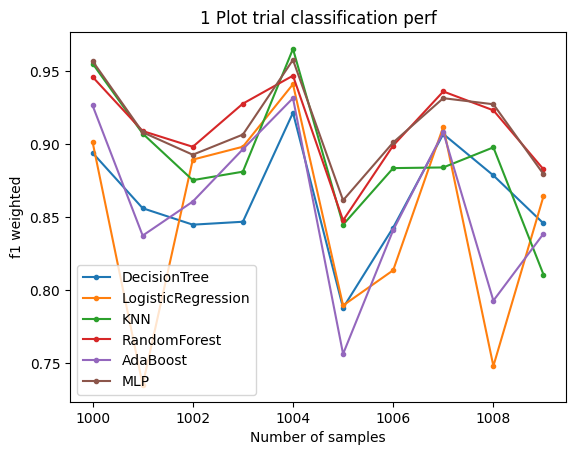

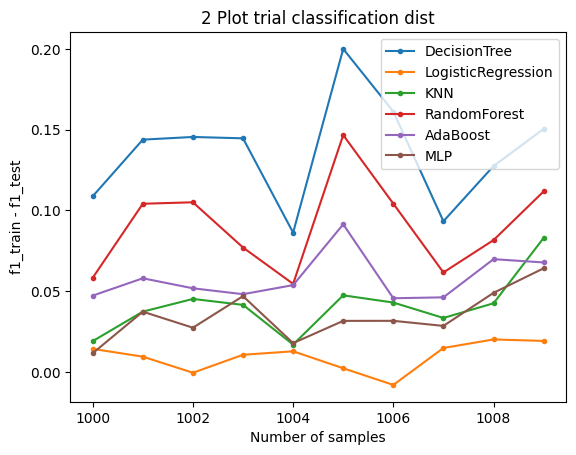

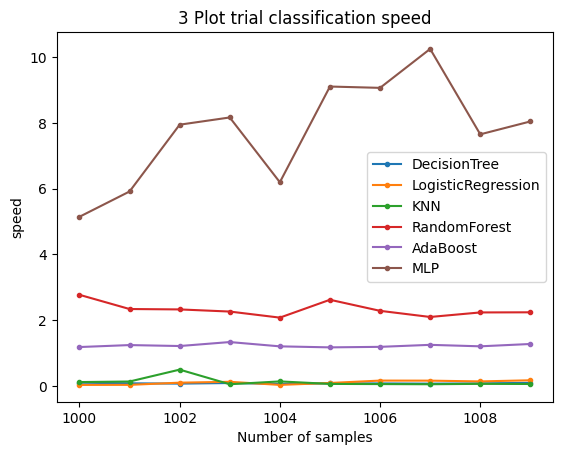

In [ ]:
plot(x_axis_values=[1000,1001,1002,1003,1004,1005,1006,1007,1008,1009], x_label="Number of samples", results=results_for_each_algorithm, title="1 Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[1000,1001,1002,1003,1004,1005,1006,1007,1008,1009], x_label="Number of samples", results=results_for_each_algorithm, title="2 Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[1000,1001,1002,1003,1004,1005,1006,1007,1008,1009], x_label="Number of samples", results=results_for_each_algorithm, title="3 Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")